In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
from IPython.display import Image
%matplotlib inline

In [3]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
(70000,)


**Normalize to [-1, 1] range:**

In [4]:
X = ((X / 255.) - .5) * 2


**Visualize the first digit of each class:**

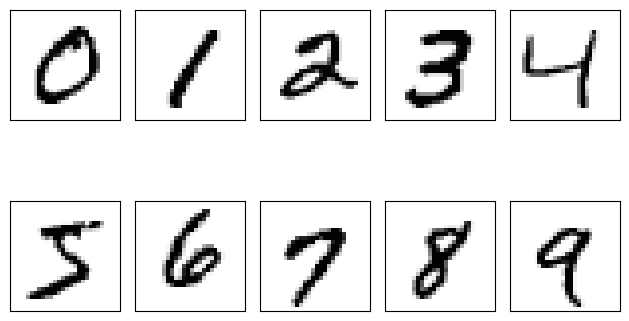

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

**Visualize 25 different versions of "7":**

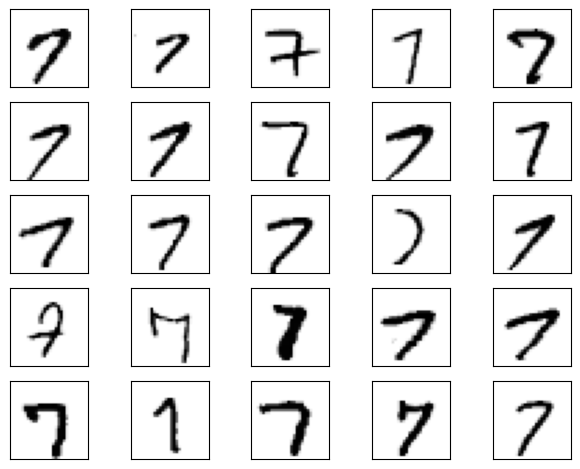

In [6]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

**Split into training, validation, and test set:**

In [7]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=21000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=21000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

# Implementing an ANN

In [8]:
import numpy as np


In [9]:
##########################
### MODEL
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def softmax(x):
    return(np.exp(x)/(np.exp(x).sum()))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h1 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h1 = np.zeros(num_hidden)

        self.weight_h2 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h2 = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        z_h2 = np.dot(x, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)



        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = softmax(z_out)
        return a_h1,a_h2, a_out

    def backward(self, x, a_h1,a_h2, a_out, y):

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h2

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h2 = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)

        # [n_examples, n_hidden]
        d_a_h__d_z_h2 = a_h2 * (1. - a_h2) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h2 = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h2 = np.dot((d_loss__a_h2 * d_a_h__d_z_h2).T, d_z_h__d_w_h2)
        d_loss__d_b_h2 = np.sum((d_loss__a_h2 * d_a_h__d_z_h2), axis=0)


        d_z_out__a_h1 = self.weight_h2

        # output dim: [n_examples, n_hidden]
        d_loss__a_h1 = np.dot(d_z_out__a_h2, d_z_out__a_h1)

        # [n_examples, n_hidden]
        d_a_h__d_z_h1 = a_h1 * (1. - a_h1) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h1 = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h1 = np.dot((d_loss__a_h1 * d_a_h__d_z_h1).T, d_z_h__d_w_h1)
        d_loss__d_b_h1 = np.sum((d_loss__a_h1 * d_a_h__d_z_h1), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h1, d_loss__d_b_h1,d_loss__d_w_h2, d_loss__d_b_h2)

In [10]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=500,
                     num_classes=10)

# Coding the neural network training loop

**Defining data loaders:**

In [11]:
import numpy as np

num_epochs = 20
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]


# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:

        break

    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


**Defining a function to compute the loss and accuracy**

In [12]:
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import roc_auc_score

import numpy as np
from sklearn.preprocessing import LabelBinarizer

def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


def multiclass_auc_score(y_true, y_scores):
    """
    Calculate the Area Under the ROC Curve (AUC) score for multiclass classification.

    Parameters:
        y_true (array-like): True labels for each sample.
        y_scores (array-like): Predicted scores or probabilities for each class.

    Returns:
        auc_score (float): AUC score for the multiclass classification problem.
    """
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_true)
    binarized_true = label_binarizer.transform(y_true)
    auc_score = roc_auc_score(binarized_true, y_scores, average='weighted')
    return auc_score



_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

auc = multiclass_auc_score(y_valid, probas)


print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')
print(f'Initial validation AUC: {auc*100:.1f}%')

Initial validation MSE: 0.2
Initial validation accuracy: 10.4%
Initial validation AUC: 47.8%


In [13]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)


    for i, (features, targets) in enumerate(minibatch_gen):


        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)


        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples

    return mse, acc

In [14]:
mse, acc  = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.2
Initial valid accuracy: 10.4%


In [15]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h1, d_loss__d_b_h1, d_loss__d_w_h2, d_loss__d_b_h2 = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h1 -= learning_rate * d_loss__d_w_h1
            model.bias_h1 -= learning_rate * d_loss__d_b_h1
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [16]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=20, learning_rate=0.1)

Epoch: 001/020 | Train MSE: 0.03 | Train Acc: 84.61% | Valid Acc: 84.79%
Epoch: 002/020 | Train MSE: 0.03 | Train Acc: 88.02% | Valid Acc: 87.65%
Epoch: 003/020 | Train MSE: 0.02 | Train Acc: 89.16% | Valid Acc: 88.75%
Epoch: 004/020 | Train MSE: 0.02 | Train Acc: 89.81% | Valid Acc: 89.37%
Epoch: 005/020 | Train MSE: 0.02 | Train Acc: 90.41% | Valid Acc: 89.89%
Epoch: 006/020 | Train MSE: 0.02 | Train Acc: 90.74% | Valid Acc: 90.18%
Epoch: 007/020 | Train MSE: 0.02 | Train Acc: 91.21% | Valid Acc: 90.55%
Epoch: 008/020 | Train MSE: 0.02 | Train Acc: 91.59% | Valid Acc: 90.89%
Epoch: 009/020 | Train MSE: 0.02 | Train Acc: 91.77% | Valid Acc: 90.95%
Epoch: 010/020 | Train MSE: 0.02 | Train Acc: 91.99% | Valid Acc: 91.36%
Epoch: 011/020 | Train MSE: 0.02 | Train Acc: 92.31% | Valid Acc: 91.54%
Epoch: 012/020 | Train MSE: 0.01 | Train Acc: 92.58% | Valid Acc: 91.70%
Epoch: 013/020 | Train MSE: 0.01 | Train Acc: 92.77% | Valid Acc: 91.85%
Epoch: 014/020 | Train MSE: 0.01 | Train Acc: 92.97

# Evaluating the neural network performance

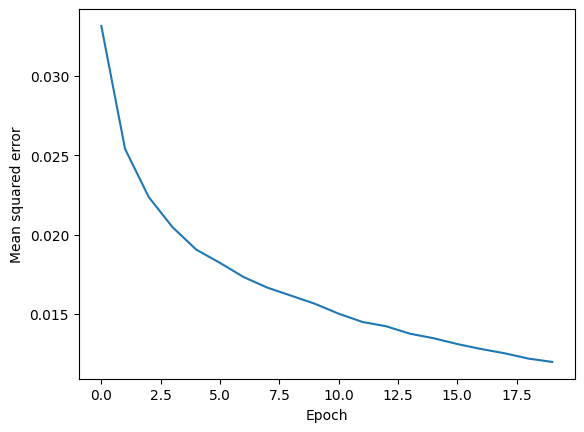

In [17]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

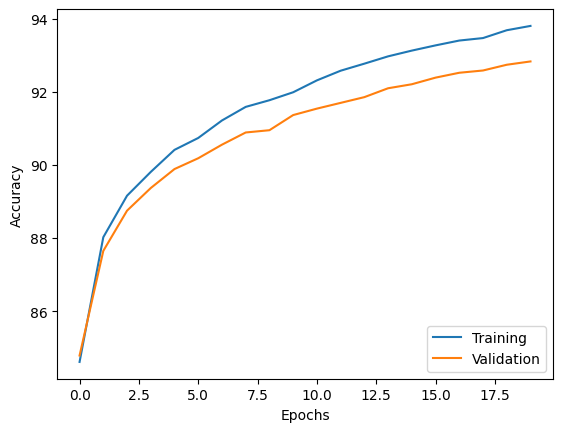

In [18]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [19]:
from sklearn.metrics import roc_auc_score

import numpy as np
from sklearn.preprocessing import LabelBinarizer

def multiclass_auc_score(y_true, y_scores):
    """
    Calculate the Area Under the ROC Curve (AUC) score for multiclass classification.

    Parameters:
        y_true (array-like): True labels for each sample.
        y_scores (array-like): Predicted scores or probabilities for each class.

    Returns:
        auc_score (float): AUC score for the multiclass classification problem.
    """
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_true)
    binarized_true = label_binarizer.transform(y_true)
    auc_score = roc_auc_score(binarized_true, y_scores, average='weighted')
    return auc_score


In [20]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)


_, probas = model.forward(X_test)
auc_test_first_model = multiclass_auc_score(y_test, probas)


print(f'Test accuracy: {test_acc*100:.2f}%')
print(f'Test AUC: {auc_test_first_model*100:.2f}%')

Test accuracy: 92.82%
Test AUC: 98.93%


# Part 1 section 4:

In [21]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
import seaborn as sns
import warnings
warnings.catch_warnings()
warnings.simplefilter("ignore")

import torch
from torchvision import datasets
from torch import nn
from torchvision.transforms import ToTensor,Lambda


from torchmetrics.classification import MulticlassAUROC

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [24]:
mnist_train = datasets.MNIST(root='data', train=True, download=True,transform=ToTensor())
mnist_test = datasets.MNIST(root='data', train=False, download=True,transform=ToTensor())

In [25]:
X_train = np.array([np.array(mnist_train[i][0]) for i in range(len(mnist_train))])
X_test = np.array([np.array(mnist_test[i][0]) for i in range(len(mnist_test))])
y_train = np.array([np.array(mnist_train[i][1]) for i in range(len(mnist_train))])
y_test = np.array([np.array(mnist_test[i][1]) for i in range(len(mnist_test))])

In [26]:
from torch.utils.data import Dataset,DataLoader
from torchvision.io import read_image
import pandas as pd
import os
class MNIST_dataset(Dataset):
    def __init__(self,path_to_imgs,labels_file,transform=None,trarget_transform=None):
        ## assumptions:
        ## labels_file contains filename and label for that file
        self.labels = pd.read_csv(labels_file)
        self.path_to_imgs = path_to_imgs
        self.transform = transform
        self.target_transform = trarget_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        path_to_imgs = os.path.join(self.path_to_imgs,self.labels.iloc[idx,0])
        image = read_image(path_to_imgs)
        label = self.labels.iloc[idx,1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [27]:
from torch.utils.data import DataLoader
from torch import nn
train_loader = DataLoader(mnist_train,batch_size=100,shuffle=True)
test_loader = DataLoader(mnist_test,batch_size=100,shuffle=True)

In [28]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(28*28,500), # hiddien layer
            nn.Sigmoid(),
            nn.Linear(500,10),
            nn.Softmax(dim=1)
        )

    def forward(self,x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

model = MLP().to(device)
model

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=500, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)

In [29]:
learning_rate = 1e-3
epochs = 20
batch_size = 100

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

history = []

def train_loop(data_loader,model,device,loss_fn,optimizer,print_every_n=150):
    model.train()
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    train_loss=0
    tp=0
    for batch,(X,y) in enumerate(data_loader):
        X = X.to(device)
        y = y.to(dtype=torch.long)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred,y)
        train_loss += loss
        tp += (y==pred.argmax(1)).type(torch.float).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch%print_every_n==0:
            loss, current = loss.item(), batch*len(X)
            print(f'loss={loss:.3f}, {current} samples / {size}')

    train_loss /= num_batches
    train_acc = tp/size

    return train_loss,train_acc

def test_loop(data_loader,model,device,loss_fn):
    model.eval()
    size=len(data_loader.dataset)
    num_batches = len(data_loader)
    test_loss=0
    tp=0
    auc = 0
    auroc = MulticlassAUROC(num_classes=10, average="macro", thresholds=5)
    with torch.no_grad():
        for X,y in data_loader:
            X = X.to(device)
            y = y.to(dtype=torch.long)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred,y).item()
            tp += (y==pred.argmax(1)).type(torch.float).sum().item()
            auc_test = auroc(pred,y)

    test_loss /= num_batches
    test_acc = tp/size
    auc = auc_test
    print(f'accuracy = {test_acc}, test_loss = {test_loss:2f}')
    return test_loss,test_acc ,auc

In [30]:
history = []
for i in range(epochs):
    train_loss,train_acc = train_loop(train_loader,model,device,loss_fn,optimizer)
    test_loss,test_acc,auc = test_loop(test_loader,model,device,loss_fn)
    history.append({'train_loss':train_loss.detach().cpu().numpy(),'val_loss':test_loss,'train_acc':train_acc,'val_acc':test_acc ,'auc':auc})

loss=2.302, 0 samples / 60000
loss=1.662, 15000 samples / 60000
loss=1.653, 30000 samples / 60000
loss=1.568, 45000 samples / 60000
accuracy = 0.9168, test_loss = 1.557974
loss=1.561, 0 samples / 60000
loss=1.545, 15000 samples / 60000
loss=1.564, 30000 samples / 60000
loss=1.532, 45000 samples / 60000
accuracy = 0.9361, test_loss = 1.532450
loss=1.526, 0 samples / 60000
loss=1.549, 15000 samples / 60000
loss=1.551, 30000 samples / 60000
loss=1.524, 45000 samples / 60000
accuracy = 0.9446, test_loss = 1.522579
loss=1.544, 0 samples / 60000
loss=1.491, 15000 samples / 60000
loss=1.517, 30000 samples / 60000
loss=1.508, 45000 samples / 60000
accuracy = 0.9513, test_loss = 1.514088
loss=1.505, 0 samples / 60000
loss=1.519, 15000 samples / 60000
loss=1.483, 30000 samples / 60000
loss=1.484, 45000 samples / 60000
accuracy = 0.9566, test_loss = 1.507579
loss=1.515, 0 samples / 60000
loss=1.504, 15000 samples / 60000
loss=1.491, 30000 samples / 60000
loss=1.516, 45000 samples / 60000
accuracy

In [31]:
history = pd.DataFrame(history)

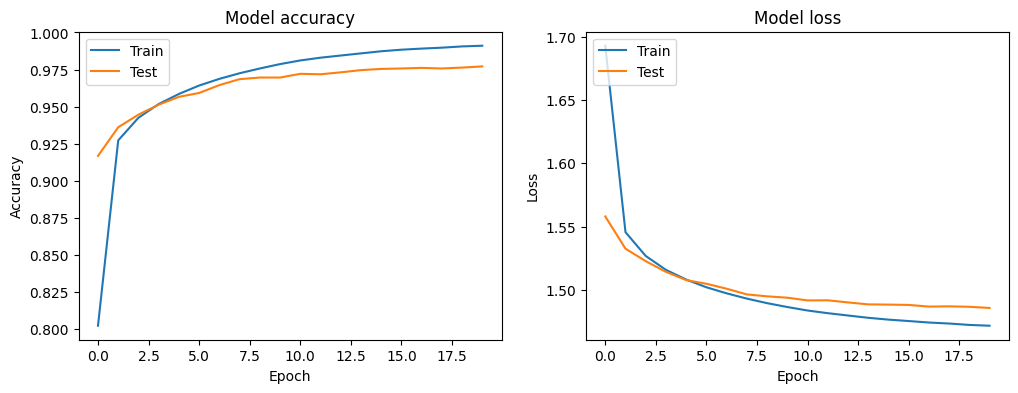

In [32]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(history['train_acc'])
ax[0].plot(history['val_acc'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax[1].plot(history['train_loss'])
ax[1].plot(history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Test'], loc='upper left')
plt.show()


In [39]:
print(f'Test AUC for first model: {auc_test_first_model*100:.2f}%')
auc_test_second_model = history['auc']
print(f'Test AUC for second model: {auc_test_second_model*100:.2f}%')



Test AUC for first model: 98.93%
Test AUC for second model: 98.73%
